<a href="https://colab.research.google.com/github/hendrikyong/CVNL_Assignment_1/blob/main/CVNL_P02_GP01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import os
import torch
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Download dataset from KaggleHub
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

#define paths to the training and testing data directories
data_dir = '/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train'
# no longer using the test_dir because there is only 1 image per class and there is simply not enough for evaluation
# test_dir = '/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_test/asl_alphabet_test'

# Check dataset files
print("Path to dataset:", data_dir)

Path to dataset: /root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train


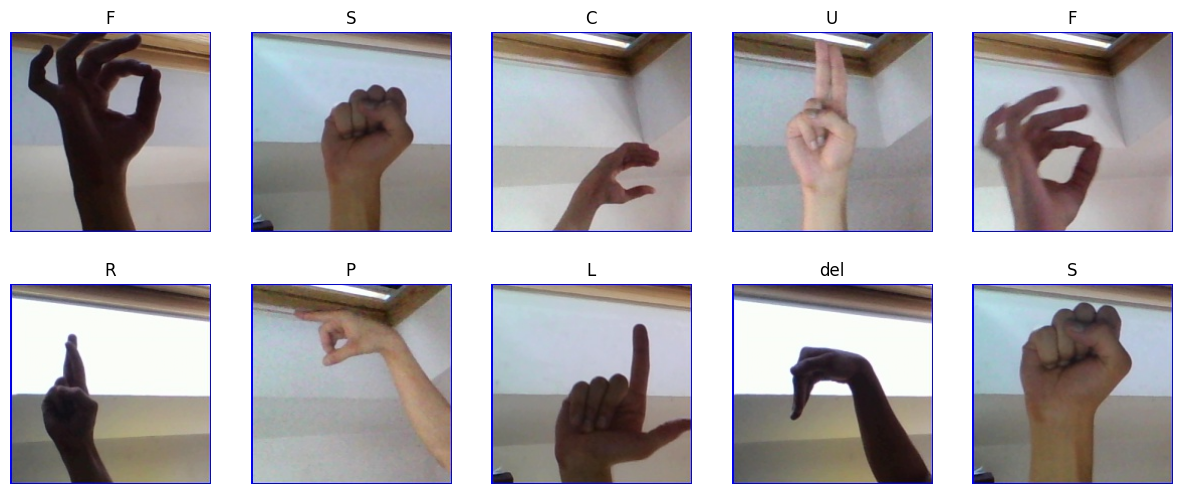

In [2]:
import random

# Get class names
#load full dataset (folders act as labels)
full_dataset = datasets.ImageFolder(root=data_dir)
classes = full_dataset.classes

# Define a transform to convert PIL images to tensors
to_tensor = transforms.ToTensor()

# Pick 10 random indices
random_indices = random.sample(range(len(full_dataset)), 10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i, idx in enumerate(random_indices):
    img, label = full_dataset[idx]  # Get PIL image and label
    img = to_tensor(img)  # Convert to tensor
    img = img.permute(1, 2, 0)  # Change shape from (C, H, W) to (H, W, C)

    axes[i].imshow(img)
    axes[i].set_title(classes[label])  # Display class label
    axes[i].axis("off")

plt.show()


In [3]:
#zhi heng
#Define helper function to calculate mean and std
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for images, _ in loader:
        images = images.view(images.size(0), images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(dataset)
    std /= len(dataset)
    return mean, std

#Calculate dataset-specific mean and std
raw_transform = transforms.Compose([
    transforms.ToTensor()
])
raw_dataset = datasets.ImageFolder(root=data_dir, transform=raw_transform)
mean, std = calculate_mean_std(raw_dataset)
print(f"Dataset Mean: {mean}, Std: {std}")

Dataset Mean: tensor([0.5189, 0.4990, 0.5145]), Std: tensor([0.2038, 0.2329, 0.2405])


In [4]:
# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.RandomCrop(128, padding=4),
    #kernel = filter used to blur the image, sigma = to blur the image by how much
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=0.7),
    #how much to distort the image by, probabilty of applying distortion to images
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [5]:
#load full dataset (folders act as labels)
full_dataset = datasets.ImageFolder(root=data_dir)

#train test split
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

#applying transformation after the split
train_dataset.dataset.transform = train_transform

#creating dataloaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

#print dataset summary
print(f"Total images: {len(full_dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Testing images: {len(test_dataset)}")

Total images: 87000
Training images: 60899
Validation images: 13050
Testing images: 13051


In [6]:
#model cnn model
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
'''
typical architecture of a CNN
1. input
2. conv
3. relu
4. pooling
5. fully connected layers
5. output pred

considerations:
how many conv layers do i need for feature extraction?
how many hidden layers?
how many channels?
'''

class CNN(nn.Module):
    def __init__(self, num_classes=29):
        super(CNN, self).__init__()

        self.model = nn.Sequential(
            #conv1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #conv2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #conv3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        x = self.model(x)
        #print(x.shape)
        x = self.fc(x)
        return x

In [7]:
def train(model, train_loader, val_loader, loss_func, optimizer, device, epochs):
    model.to(device)  # Ensure model is on the correct device
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss, correct_train, total_train = 0.0, 0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=True)

        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += targets.size(0)
            correct_train += predicted.eq(targets).sum().item()

            progress_bar.set_postfix({
                "Loss": f"{epoch_train_loss / (batch_idx + 1):.4f}",
                "Accuracy": f"{100. * correct_train / total_train:.2f}%"
            })

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        epoch_val_loss, correct_val, total_val = 0.0, 0, 0
        val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=True)  # Add tqdm here for validation

        with torch.no_grad():
            for inputs, targets in val_progress_bar:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_func(outputs, targets)
                epoch_val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += targets.size(0)
                correct_val += predicted.eq(targets).sum().item()

                val_progress_bar.set_postfix({
                    "Loss": f"{epoch_val_loss / (len(val_loader)):.4f}",
                    "Accuracy": f"{100. * correct_val / total_val:.2f}%"
                })

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_accuracy = 100. * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Plot graphs
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.show()

In [8]:
def test(model, test_loader, criterion, device):
    model.eval()  # Set model to eval mode
    test_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Testing", leave=True,
                             bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            progress_bar.set_postfix({
                "Loss": f"{test_loss / (batch_idx + 1):.4f}",
                "Accuracy": f"{100. * correct / total:.2f}%"
            })

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100. * correct / total
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    return avg_test_loss, test_accuracy, y_true, y_pred

In [ ]:
#define model, loss function, optimizer, etc.
#check if gpu available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device)
else:
    device = torch.device("cpu")
    print(device)

num_classes = 29
epochs = 10
lr = 1e-4
criterion = nn.CrossEntropyLoss()
model = CNN(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Call the train function
train(model, train_loader, val_loader, criterion, optimizer, device, epochs=epochs)
avg_test_loss, test_accuracy, y_true, y_pred = test(model, val_loader, criterion, device)

cuda


Epoch 1/10 [Val]: 100%|██████████| 204/204 [01:02<00:00,  3.26it/s, Loss=2.1247, Accuracy=36.58%]


Epoch 1: Train Loss: 2.8553, Train Acc: 16.69% | Val Loss: 2.1247, Val Acc: 36.58%


Epoch 2/10 [Val]: 100%|██████████| 204/204 [01:05<00:00,  3.11it/s, Loss=1.5781, Accuracy=53.09%]


Epoch 2: Train Loss: 2.0403, Train Acc: 35.70% | Val Loss: 1.5781, Val Acc: 53.09%


Epoch 3/10 [Val]: 100%|██████████| 204/204 [01:05<00:00,  3.11it/s, Loss=1.2550, Accuracy=61.26%]


Epoch 3: Train Loss: 1.6594, Train Acc: 45.97% | Val Loss: 1.2550, Val Acc: 61.26%


Epoch 4/10 [Val]: 100%|██████████| 204/204 [01:04<00:00,  3.19it/s, Loss=1.0568, Accuracy=68.09%]


Epoch 4: Train Loss: 1.4332, Train Acc: 52.57% | Val Loss: 1.0568, Val Acc: 68.09%


Epoch 5/10 [Val]: 100%|██████████| 204/204 [01:04<00:00,  3.16it/s, Loss=0.9286, Accuracy=71.51%]


Epoch 5: Train Loss: 1.2648, Train Acc: 57.66% | Val Loss: 0.9286, Val Acc: 71.51%


Epoch 6/10 [Val]: 100%|██████████| 204/204 [01:06<00:00,  3.09it/s, Loss=0.8210, Accuracy=74.72%]


Epoch 6: Train Loss: 1.1408, Train Acc: 61.20% | Val Loss: 0.8210, Val Acc: 74.72%


Epoch 7/10 [Val]: 100%|██████████| 204/204 [01:04<00:00,  3.18it/s, Loss=0.7193, Accuracy=78.44%]


Epoch 7: Train Loss: 1.0401, Train Acc: 64.62% | Val Loss: 0.7193, Val Acc: 78.44%


Epoch 8/10 [Val]: 100%|██████████| 204/204 [01:04<00:00,  3.14it/s, Loss=0.6645, Accuracy=80.05%]


Epoch 8: Train Loss: 0.9652, Train Acc: 67.08% | Val Loss: 0.6645, Val Acc: 80.05%


Epoch 9/10 [Val]: 100%|██████████| 204/204 [01:04<00:00,  3.17it/s, Loss=0.5972, Accuracy=81.91%]


Epoch 9: Train Loss: 0.8892, Train Acc: 69.46% | Val Loss: 0.5972, Val Acc: 81.91%


Epoch 10/10 [Train]:  36%|███▌      | 343/952 [02:02<04:29,  2.26it/s, Loss=0.8511, Accuracy=70.73%]

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true and y_pred are already defined
y_true = y_true  # List or array of true labels
y_pred = y_pred  # List or array of predicted labels

# Define class names (A-Z, 'del', 'space', 'nothing')
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'space', 'nothing']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1-Score: {f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()